## Notebook 01a: Understanding the sub-SEVIR Classification ML Models 

### Goal: Interogate the pre-trained classification ML models 

#### Background 

In the [previous notebook](https://github.com/ai2es/tai4es-trustathon-2022/blob/main/severe/notebooks/Notebook_00a_Train_Classification_models.ipynb), we trained and evaluated classification models on the sub-SEVIR dataset. The models performed well on an independent dataset as the predictions were reliable, discriminated between events and non-events, and discriminated between false alarms and hits. Given that differences in model performances are practically insignificant, we will limit our focus to the **logistic regression** model. Logistic regression is a less complex, linear-based model and anticipating its future behavior will be an easier task. 

<div class="alert alert-block alert-warning"><b>Optional Task: </b> Repeat the following tasks, but for the random forest (RF) and gradient-boosted trees (GBT). The model performances of GBT and RF are similar to logistic regression, but did they learn the same things? To run those models, replace the estimator_name below with 'RF or 'GBT'.</div>

#### Primary Tasks

1. Determine the important features.
2. Assess the learned relationships. 
3. Explain individual predictions.


#### Secondary Tasks
1. Run the skexplain code yourself and change different inputs 
2. Determine whether the model can be simplified.
3. Re-run this notebook for the RF and GBT models

In [1]:
# Add ../scripts to our path so we can import functions from there.
import sys,os
sys.path.append('../scripts')        
from util import load_ml_data
from verification import plot_verification
from plotting_config import display_feature_names, color_dict

### Import the neccesary third-party packages

In [2]:
#needed packages 
import numpy as np
import pandas as pd
import joblib
import skexplain
import shap

### Load the data. 

The data has been pre-split into training, validation, and testing datasets. 

In [3]:
# Load the data.
X_train, y_train, X_val, y_val, X_test, y_test = load_ml_data()

### Load the ML models. 

For this notebook, we will load the logistic regression model, but we encourage you to re-run this notebook for the RF and GBT models. To run one of those models, change the `'LR'` below with `'RF'` or `'GBT'`.

In [4]:
# Load the pre-trained ML models into the skexplain format (estimator name, estimator)
estimator_name = 'LR'
estimators = [(estimator_name, 
              joblib.load(f'../models/{estimator_name}_classification.joblib'))]

## Task 1. Analyze the Important Features 

An initial task for understanding an ML model is understanding the important features – those features that contribute most to the model's performance. If the model performs well on independent data, then these features might provide insight into the data-generating process. The common approach for assessing feature importance is the permutation importance method. There are different flavors of permutation importance, which were covered in the lecture series. For this tutorial, we will use four versions of permutation importance to understand the top predictors: 

* Backward Single-pass
* Backward Multi-pass
* Forward Single-pass
* Forward Multi-pass

It is crucial to evaluate multiple explainability methods as no single method has been found to perform significantly better than another method. Our task is to summarize the different rankings and hopefully improve our estimate of the top features. 


When explaining global characteristics of a model like top features and/or learned relationships, we want to use the training dataset. The goal of measuring feature importance or learned relationships is to quantify how the model relies on each feature and not how well the model generalizes to unseen data. If the ML model learned a pattern in the training dataset that it is underrepresented in the independent dataset it can bias the feature ranking. For example, imagine we had an ML model trained to predict subfreezing road surface temperatures. If the ML model learned that frozen road surfaces only occur when 2-m temperatures are $<$ -10 $^{\circ}$C, but the independent dataset is mainly composed of 2-m temperature samples between -5--0$^{\circ}$C, then 2-m temperature would have reduced importance. Therefore, the feature importances and the learned relationships in this tutorial are evaluated using the training dataset.

In [5]:
# Initialize the ExplainToolkit from skexplain. We will be able to run all the explainability 
# methods and corresponding plotting from `explainer`. 
explainer = skexplain.ExplainToolkit(estimators, X_train, y_train)

### Task 1a. (optional) Run the skexplain code yourself. 

<div class="alert alert-block alert-danger"><b>Warning: </b> If you are running this notebook for 'RF' or 'GBT', then you need to convert the following cell back to 'Code' and run it. It will take a few minutes (3-4 mins). </div>

For more information on the permutation importance in scikit-explain, check out this [tutorial] (https://github.com/monte-flora/scikit-explain/blob/master/tutorial_notebooks/permutation_importance_tutorial.ipynb). Play around with `subsample` size or the `evaluation_fn` used. Is there any sensitivity? 

In [7]:
# Load the permutation importance results.
# If you choose a different metric, then change it here to load it. 
metric = 'auc'
results_backward = explainer.load(f'../datasets/perm_imp_backward_{metric}_{estimator_name}.nc')
results_forward = explainer.load(f'../datasets/perm_imp_forward_{metric}_{estimator_name}.nc')

### Plot the Important Features. 

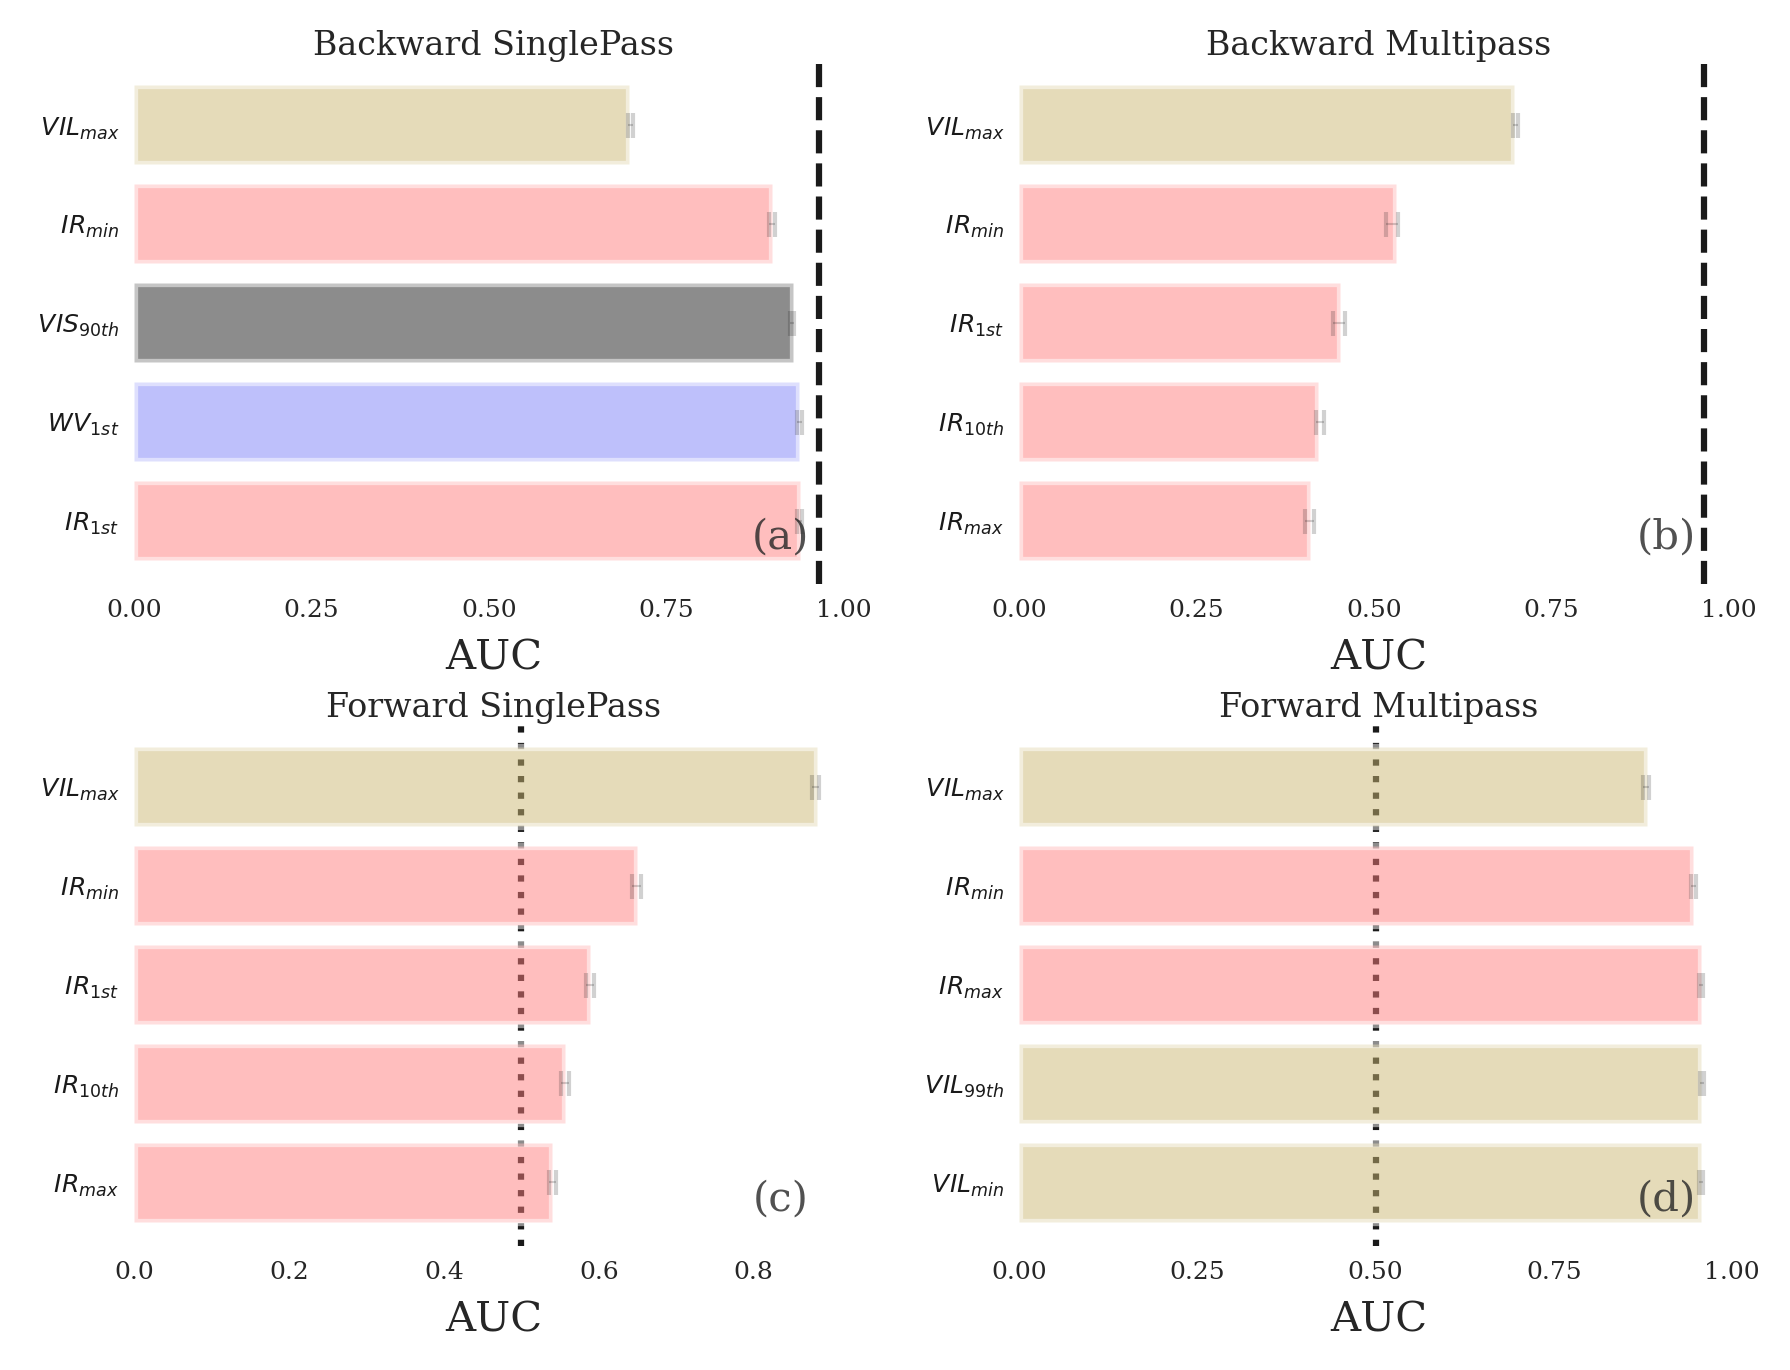

In [8]:
panels = [('backward_singlepass', estimator_name),
          ('backward_multipass',  estimator_name),
          ('forward_singlepass', estimator_name),
          ('forward_multipass',  estimator_name),
         ]

fig,axes = explainer.plot_importance(data=[results_backward, results_backward, 
                                           results_forward, results_forward], 
                                panels=panels,
                                num_vars_to_plot=5,
                                xlabels=[metric.upper()]*len(panels),
                                display_feature_names=display_feature_names, 
                                feature_colors=color_dict, 
                                n_columns=2, 
                                 )

titles = ['Backward SinglePass', 'Backward Multipass', 
          'Forward SinglePass',  'Forward Multipass', 
         ]

for ax, title in zip(axes.flat, titles):
    ax.set_title(title, pad=0.02)

The color coding is as follows: 
1. Red : Infrared (IR) brightness temperature-based features
2. Purple: Water vapor (WV) brightness temperature-based features
3. Gold: Vertically integrated liquid (VIL)-based features

The consensus from the different permutation importance methods is that spatial-maximum VIL (VIL$_{max}$) and the spatial-minimum infrared brightness temperature (IR$_{min}$) features are the most important. VIL$_{max}$ and IR${_min}$ are plausible top features as high VIL$_{max}$ values are associated with convective cores as are cold infrared temperatures due to overshooting storm tops. Beyond the top 2 features, there is only partial consensus amongst the different rankings. Remember that each method is measuring a slightly different aspect of feature importance and are not neccesarily expected to provide identical rankings. For example, backward-based methods are evaluating how model performance degrades as features are permuted while forward-based methods evaluate how much the model performance relies solely on those unpermuted features. 

For example, for the forward singlepass method, all features start permuted and then a single feature is unpermuted (repeated for each feature). In this case, with all features permuted expect VIL$_{max}$, the model achieved an AUC > 0.8. This result highlights that a majority of the model performance is based on VIL$_{max}$. For another example, for the backward multiplass, once a top feature is determined it is kept permuted before determining the next most important feature. In this case, once VIL$_{max}$ and IR$_{min}$ are both permuted, the model achieved an AUC of 0.5 indicating that all model performance is lost. This result does not mean that the other features are unimportant/useless. The correct interpretation is that the importance of the other features are heavily linked to VIL$_{max}$ and IR$_{min}$ and once the model can no longer rely on the covariate information of those features with VIL$_{max}$ and/or IR$_{min}$ (due to the permutations), their useful contributions are lost. 


<div class="alert alert-block alert-info"><b>Question 1: </b> The model task is to predict lightning flash versus no lightning flash for a storm-centered image and spatial-min and max values were found to be most important. What if our goal was predict lots of flashes (>100) versus no flashes or predict coverage? Would we expect spatial information to be more important? </div>


Let's see in the next task whether these are truly the relationships learned by the logistic regression model. 

## Task 2. Analyze the Learned Relationships

To evaluate the learned relationships we use the accumuluted local effects rather than partial dependence.
For more details on the accumulated local effects, see this [tutorial notebook](https://github.com/monte-flora/scikit-explain/blob/master/tutorial_notebooks/accumulated_local_effect_tutorial.ipynb).


In [9]:
# Get the top 2 vars. 
important_vars = explainer.get_important_vars(results_backward, n_vars=2)[estimator_name][:2]
# Compute the ALE 
ale_1d_ds = explainer.ale(features=important_vars, subsample=0.25, n_jobs=2, n_bins=20)

  0%|          | 0/2 [00:00<?, ?it/s]

(<Figure size 1800x1200 with 6 Axes>,
 array([<AxesSubplot:xlabel='$VIL_{max}$'>,
        <AxesSubplot:xlabel='$IR_{min}$'>], dtype=object))

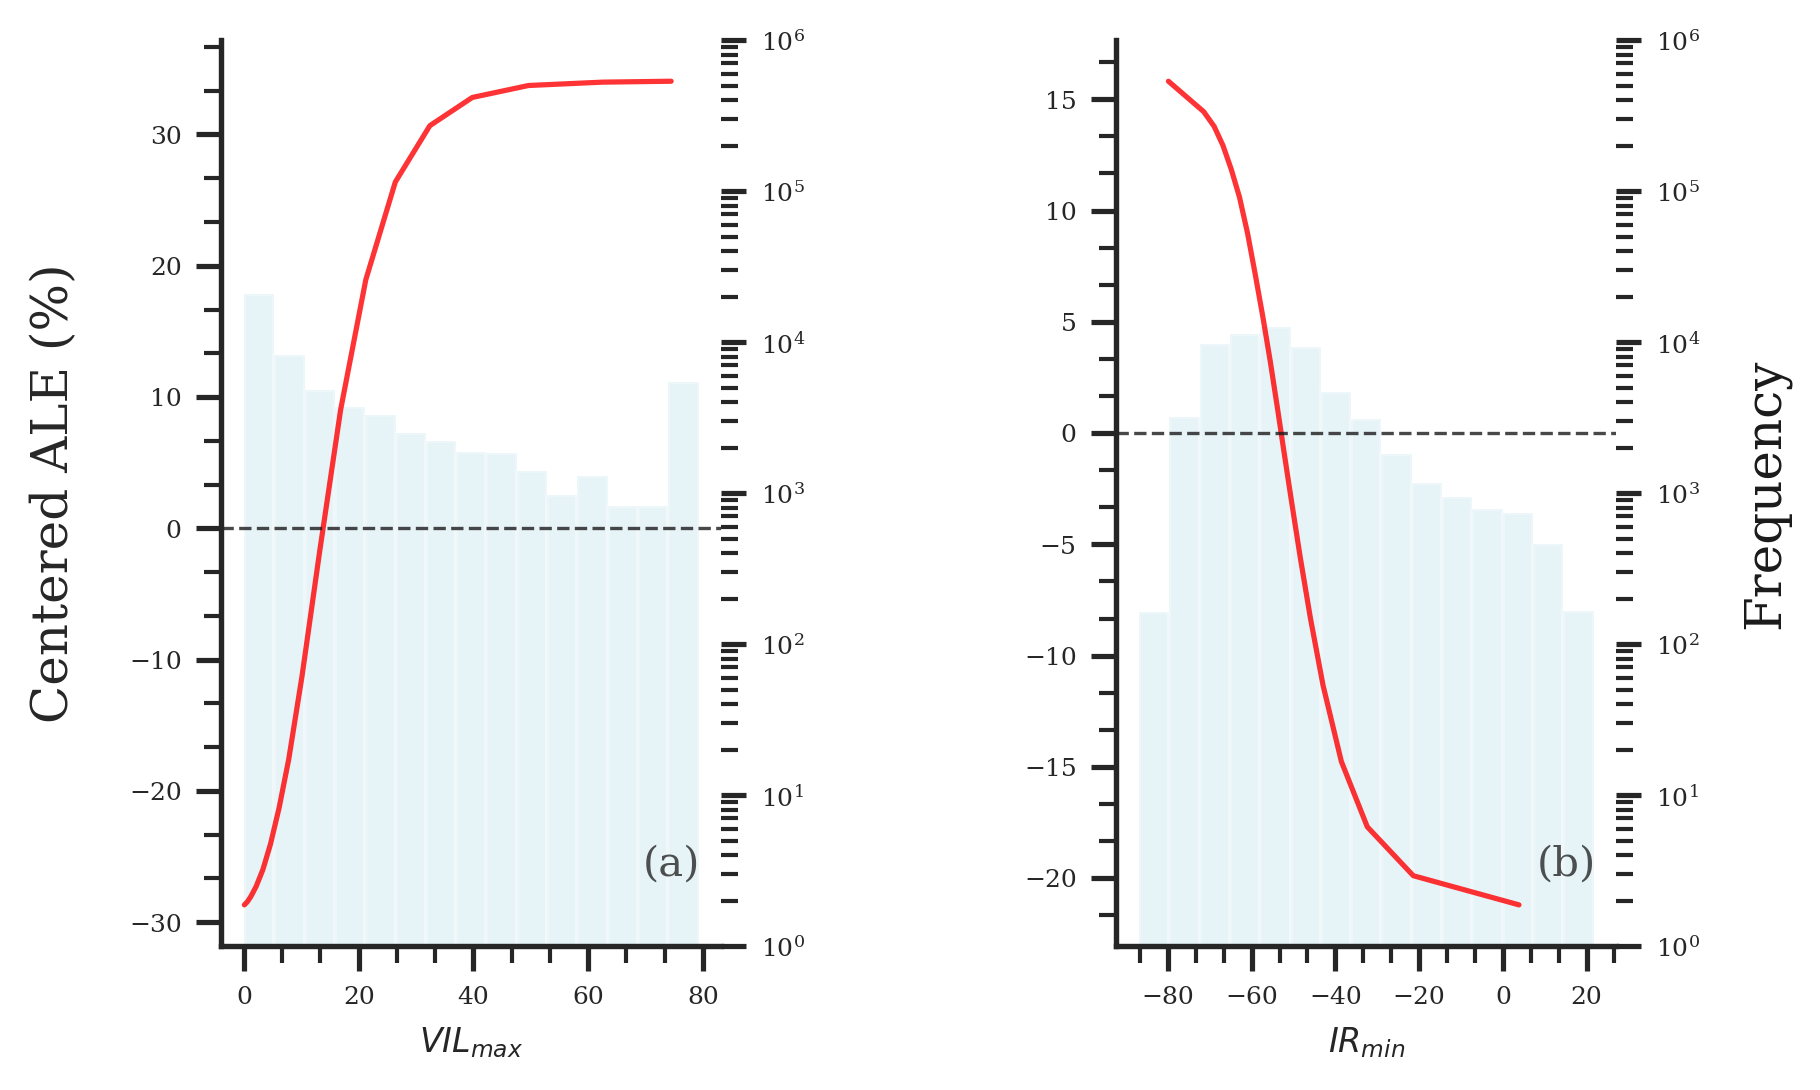

In [10]:
explainer.plot_ale(ale_1d_ds, display_feature_names=display_feature_names, figsize=(6,4))

Success! As mentioned in the previously task, we expect higher VIL$_{max}$ (panel a) values and lower IR$_{min}$ values (panel b) to contribute positively to the model prediction. At the moment, we know that the model is skillful and has learned plausible relationships. Looking close at the ALE values, we can see that the model prediction is more sensitive to changes in VIL$_{max}$ (-30-30) than IR$_{min}$ (-20-15). The greater sensitivity to VIL$_{max}$ helps explain why it is a more important feature. 

<div class="alert alert-block alert-info"><b>Question 2: </b> The model heavily relies on VIL$_{max}$ to predict lightning occurence. Is there a potential failure mode (e.g., non-meteorological clutter for VIL)? What about IR$_{min}$? </div>


<div class="alert alert-block alert-info"><b>Question 3: </b> We have a better understanding of global aspects of the model. How would you explain it to the different end-users described for this trust-a-thon? </div>

### Task 2a. (optional) Run the ALE code yourself. Also, run the PD code and plot both. 


 </div> <div class="alert alert-block alert-info"><b>Question 4 (optional): </b> Are there difference between ALE and PD? If they are different, does this impact your understanding of the model? </div>


## Task 3. Can we simplify the model? 

The ML models performed well on the testing datasets and the learned relationships were plausiable. Based on the permutation importance results, there was a strong consensus that VIL$_{max}$ and IR$_{min}$  were the most important features. Let's re-train the ML models on these two features and see if we can maintain similar model accuracy. If we can largely match the original model performance, then we have drastically improved the explainability by reducing the model to two variables.  

For automated tasks with little to no human intervention, we likely want to optimize model performance with little regard for explainability. For tasks where human decision making is required (e.g., high risk situations like severe weather forecasting), then we must balance model performance with model explainability. In some circumstances, we can greatly simplify a model without a significant loss of model performance. 



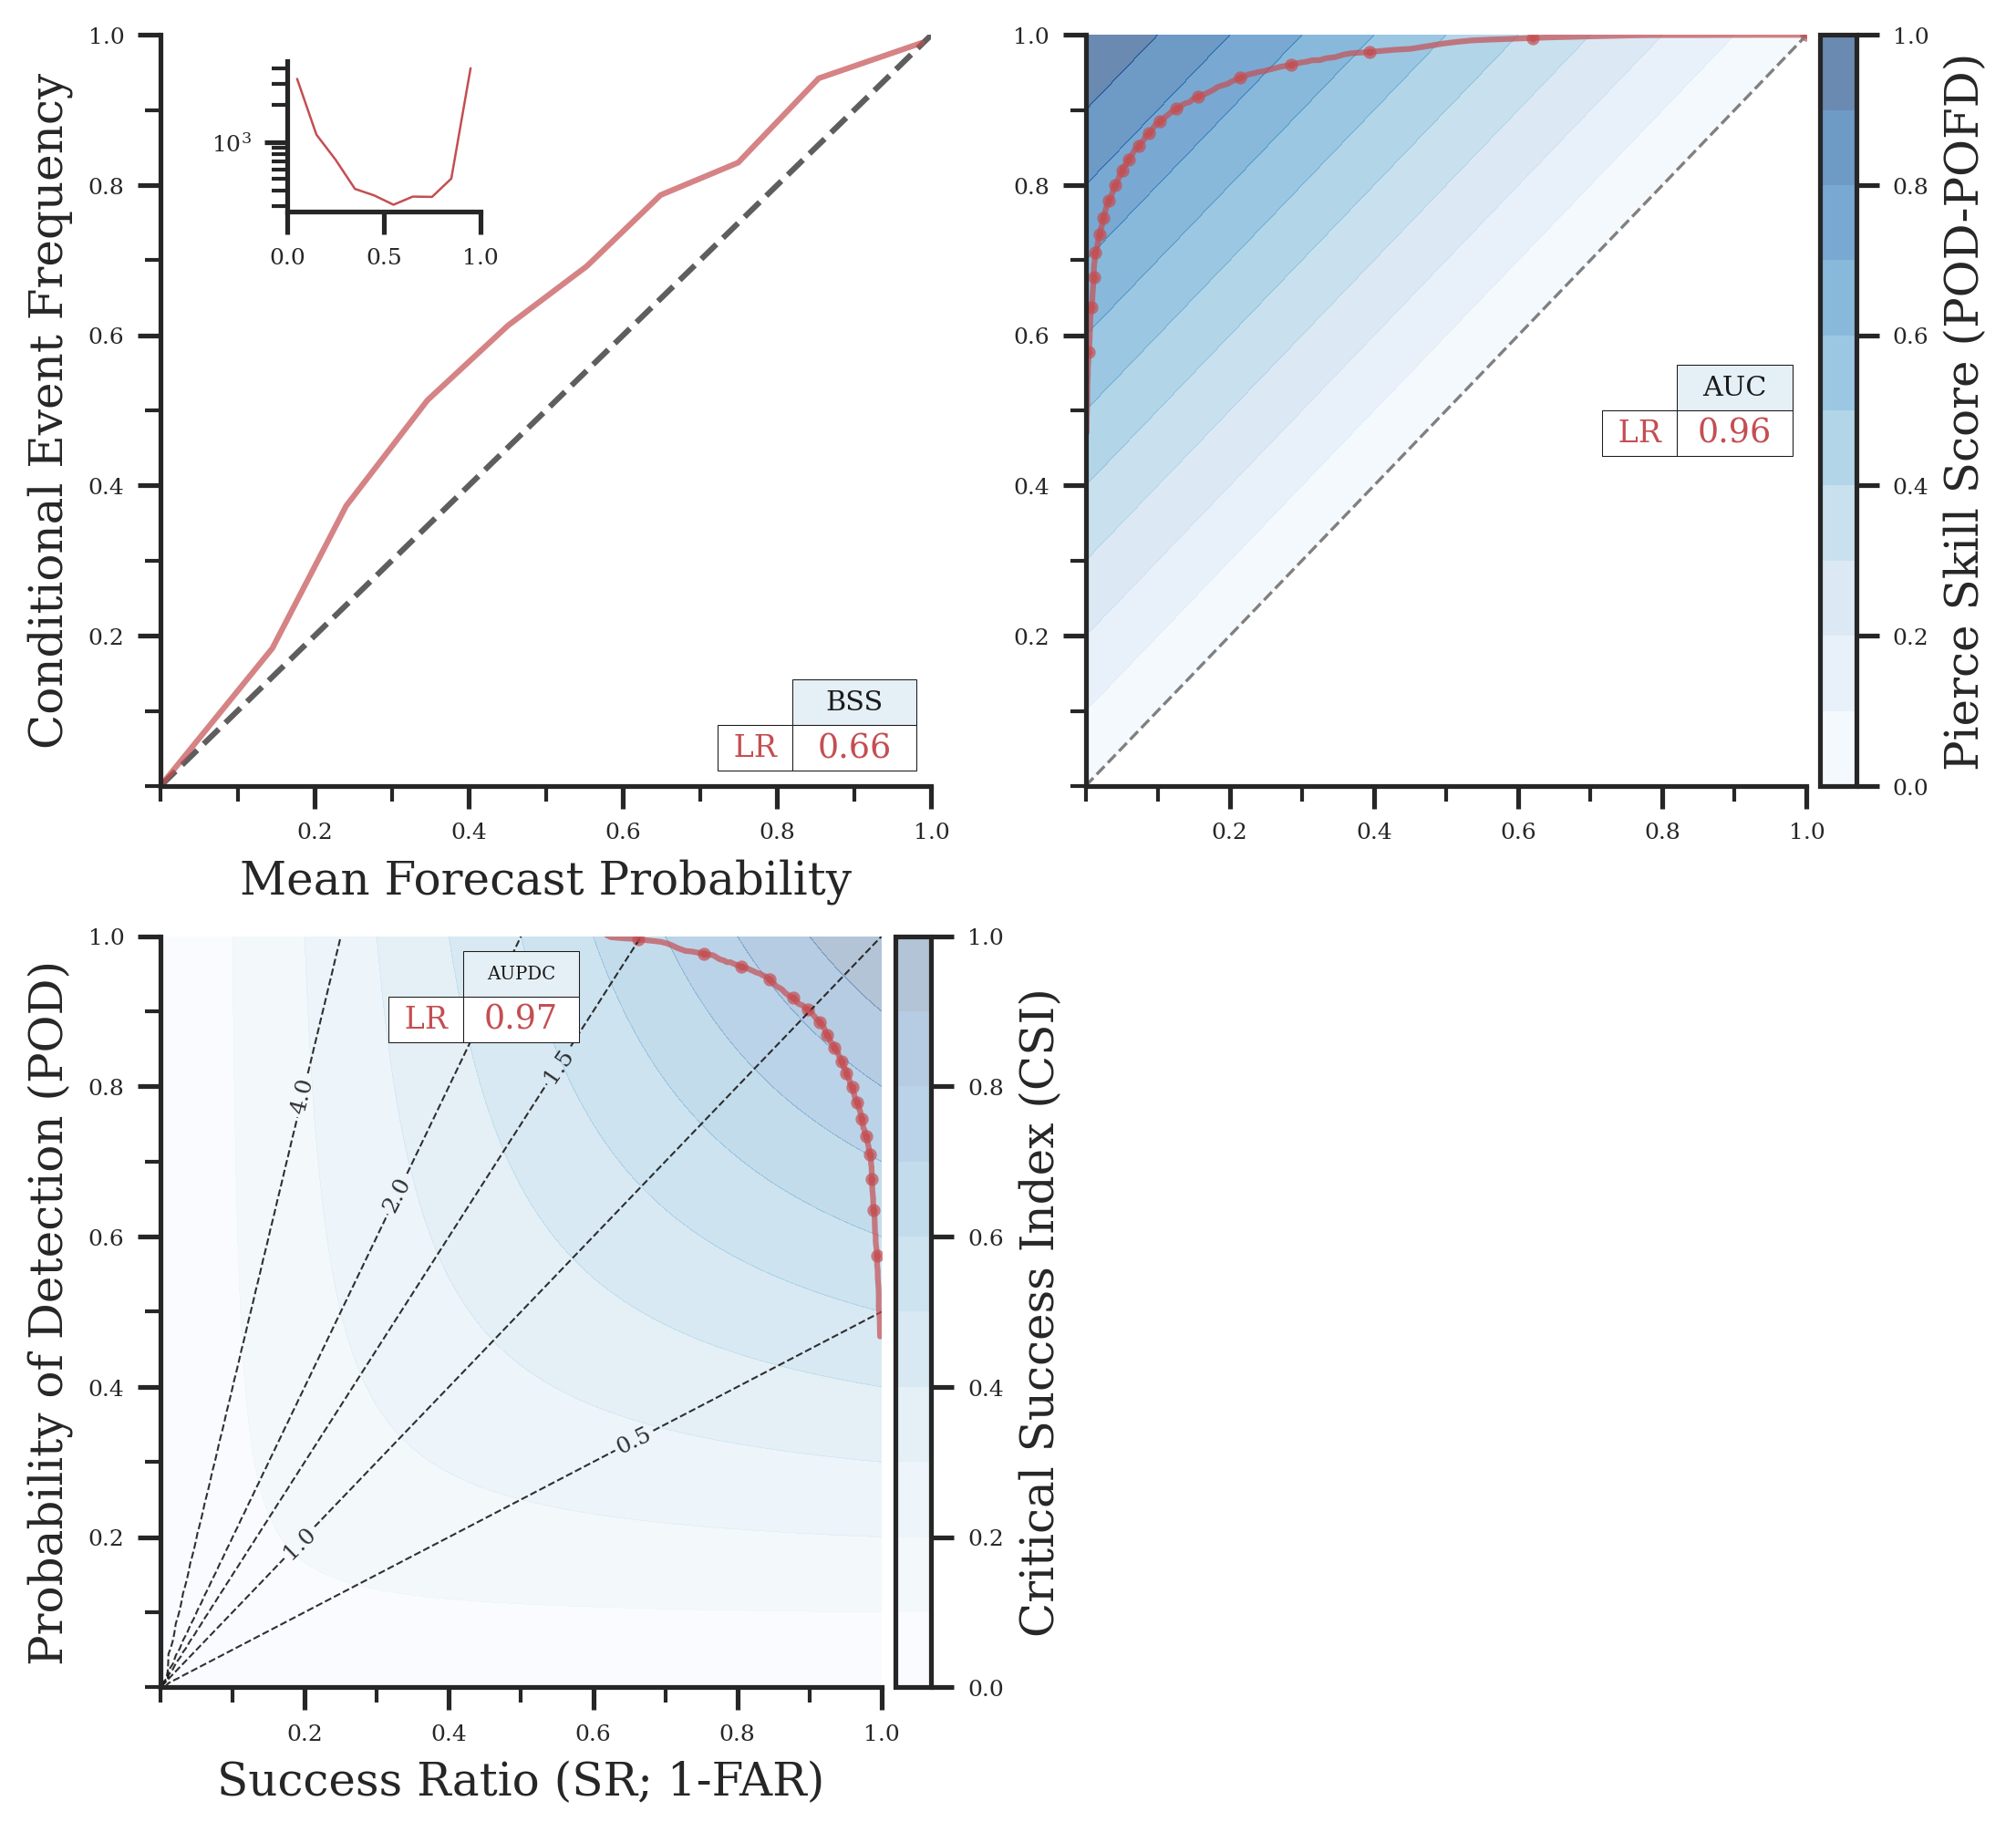

In [11]:
from sklearn.linear_model import LogisticRegression

X_train_sub = X_train[important_vars]
X_test_sub = X_test[important_vars]

X_train_sub.reset_index(drop=True, inplace=True)
X_test_sub.reset_index(drop=True, inplace=True)

lr = LogisticRegression()
lr.fit(X_train_sub, y_train)

plot_verification([('LR', lr)], X_test_sub, y_test.values)

Compared to the results in the [previous notebook](https://github.com/ai2es/tai4es-trustathon-2022/blob/main/severe/notebooks/Notebook_00a_Train_Classification_models.ipynb), the predictions have become slightly underconfident for probabilities > 40%, but the discrimination skill remains high with an AUDPC of 0.97 and AUC of 0.96. This result highlights that we can accurately predict whether an storm-centered image will contain lightning flash using only two variables! If this model were being developed for a task where human intervention was required, then we have a provided a model that is both highly accurate and understandable.  

 </div> <div class="alert alert-block alert-info"><b>Question 5: </b> Can we explain why the reliability decreased, but the discrimination was unaffected? What does that tells about this simplified model? How can we convey this to our end-users?  </div>
 


### Task 3a. (optional) Only keep spatial min and spatial max features and re-train the ML models. 

</div> <div class="alert alert-block alert-warning"><b>Optional Task: </b> If we kept only the spatial-minimum and maximum for each satellite variable (WV, IR, VIL, VI) and removed the other spatial percentile-based features, how does the model perform? Does the reliability improve? The spatial min and max features are interpretable, so we would still have an understandable model if we slightly increased the feature set.  </div>

## Task 4. Explain individual predictions

In Task 1 and 2, we explored global charactersistic of the model. We know that VIL$_{max}$ and IR$_{min}$ are the two main contributors to model performance and the learned relationships for both features is physically consistent. The model is not perfect and does make inaccurate predictions. Can we use local explainability methods to understand what the worst false alarms or worst miss looks like? Can we anticipate failure modes? In the following example, we will use Shapley values to breakdown how each feature contributes to a single model prediction. Instead of looking at random examples, we will examine average contributions to the top 5 best hits (high confidence of lightning and lightning observed), worst false alarms (high confidence, but no lightning flash), worst misses (low confidence, but lightning flash was observed), and correct negatives (low confidence and no lightning flash occurred).

Unlike the global explainability, we are free to use the training or testing dataset for local explainability. For this task, we switch to testing dataset for the following examples since we want to understand failure modes on the testing dataset.

In [12]:
results = explainer.local_contributions(method='shap', 
                                       performance_based=True,
                                       n_samples=5, 
                                       shap_kwargs={'masker' : 
                                      shap.maskers.Partition(X_train, max_samples=100, clustering="correlation"), 
                                     'algorithm' : 'auto'}
                                          )

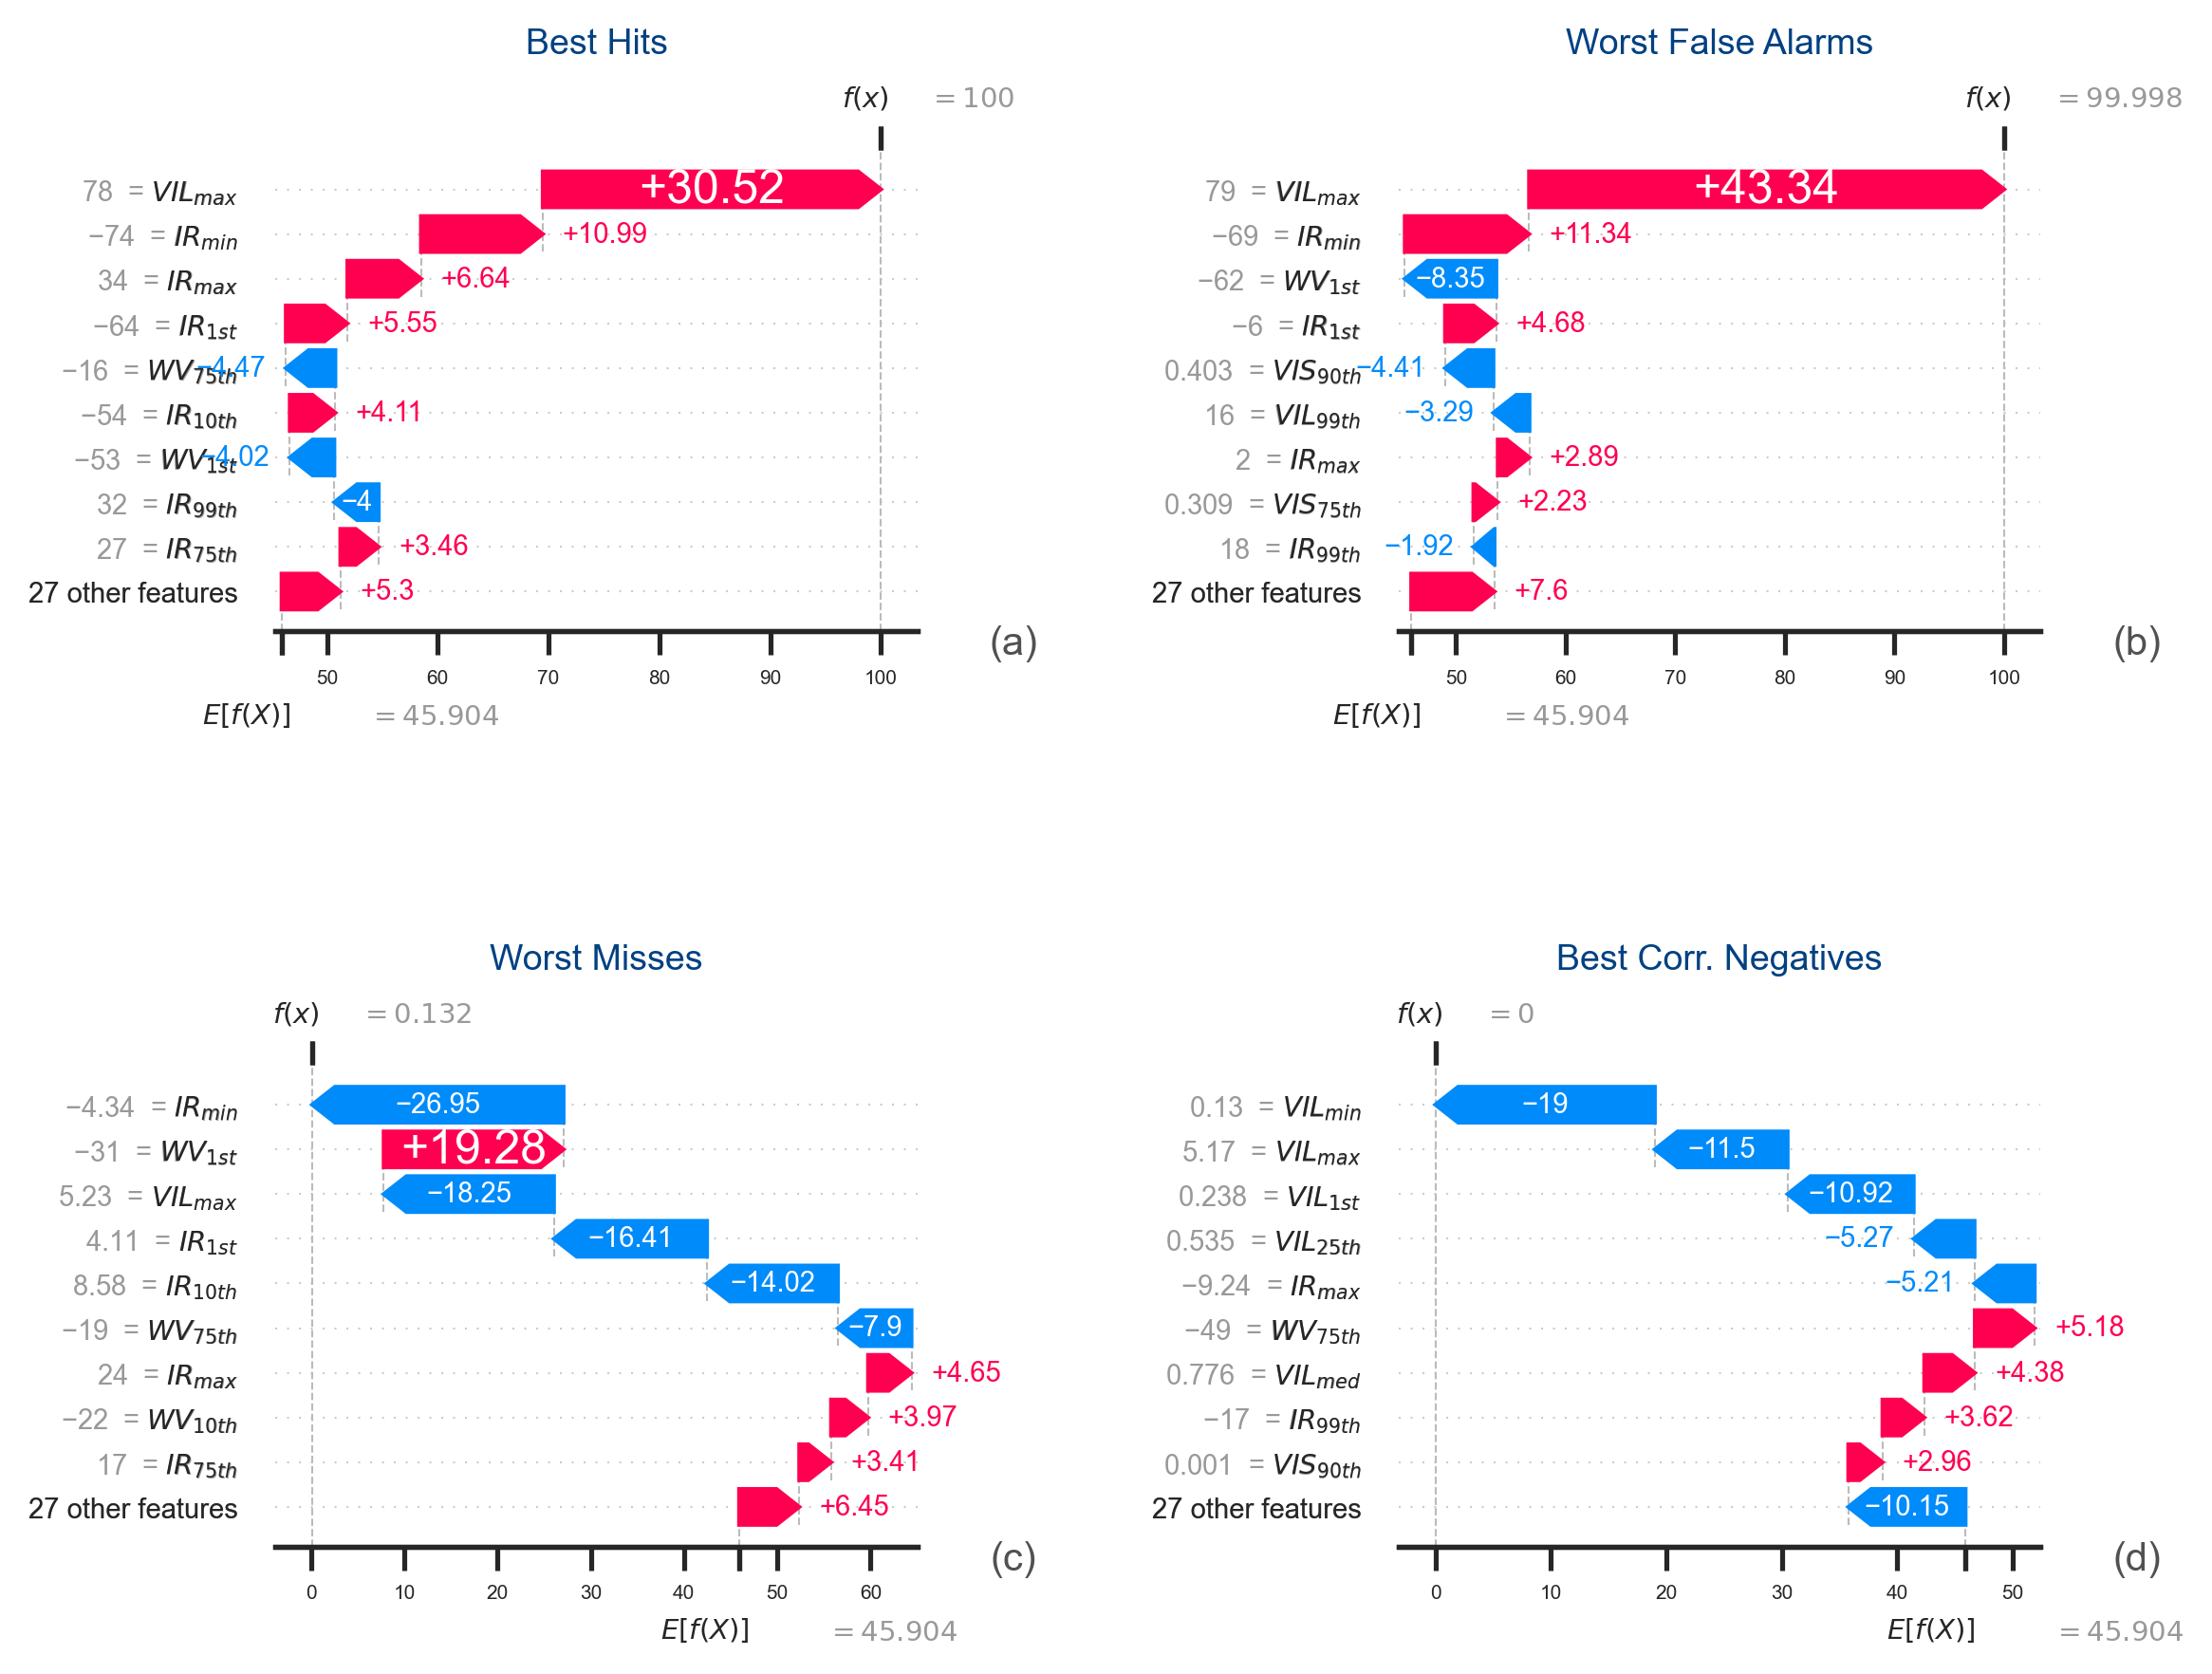

In [16]:
fig = explainer.plot_contributions(contrib=results,  
                            display_feature_names=display_feature_names,
                                   n_columns=2
                        )

The VIL$_{max}$ and IR$_{min}$ values (78 & 79 and -74 &-69, respectively) are comparable for the best hits and worst false alarms and they are the top contributors, which is consistent with the global results. Though we cannot access the full data files in this tutorial, we explored the imagery dataset to determine the source of the false alarm. In the below animation, we can see that for two timesteps, there was a data outage as the GLM lightning flash data was missing. Thus, the false alarm in this case was likely a hit. 

In [17]:
from IPython.display import Video
Video("FalseAlarm.mp4")

In this next animation, we can see the cause of the worst misses. In this case, the IR temperatures were low in the region of observed lightning flashes, but the VIL data was missing, giving erroroeously low values. 

In [18]:
from IPython.display import Video
Video("another_miss.mp4")

In both the worst false alarm and worst misses, the cause was linked to missing or bad data and not neccesarily the ML model. Given the high accuracy of the model, it is probably fair to assume that the cause of other bad false alarms and misses are linked to dad or missing data.

### Task 4a.  Marginal Misses 

In this next example, rather than looking at worst case misses, let's look at a more marginal miss example. 

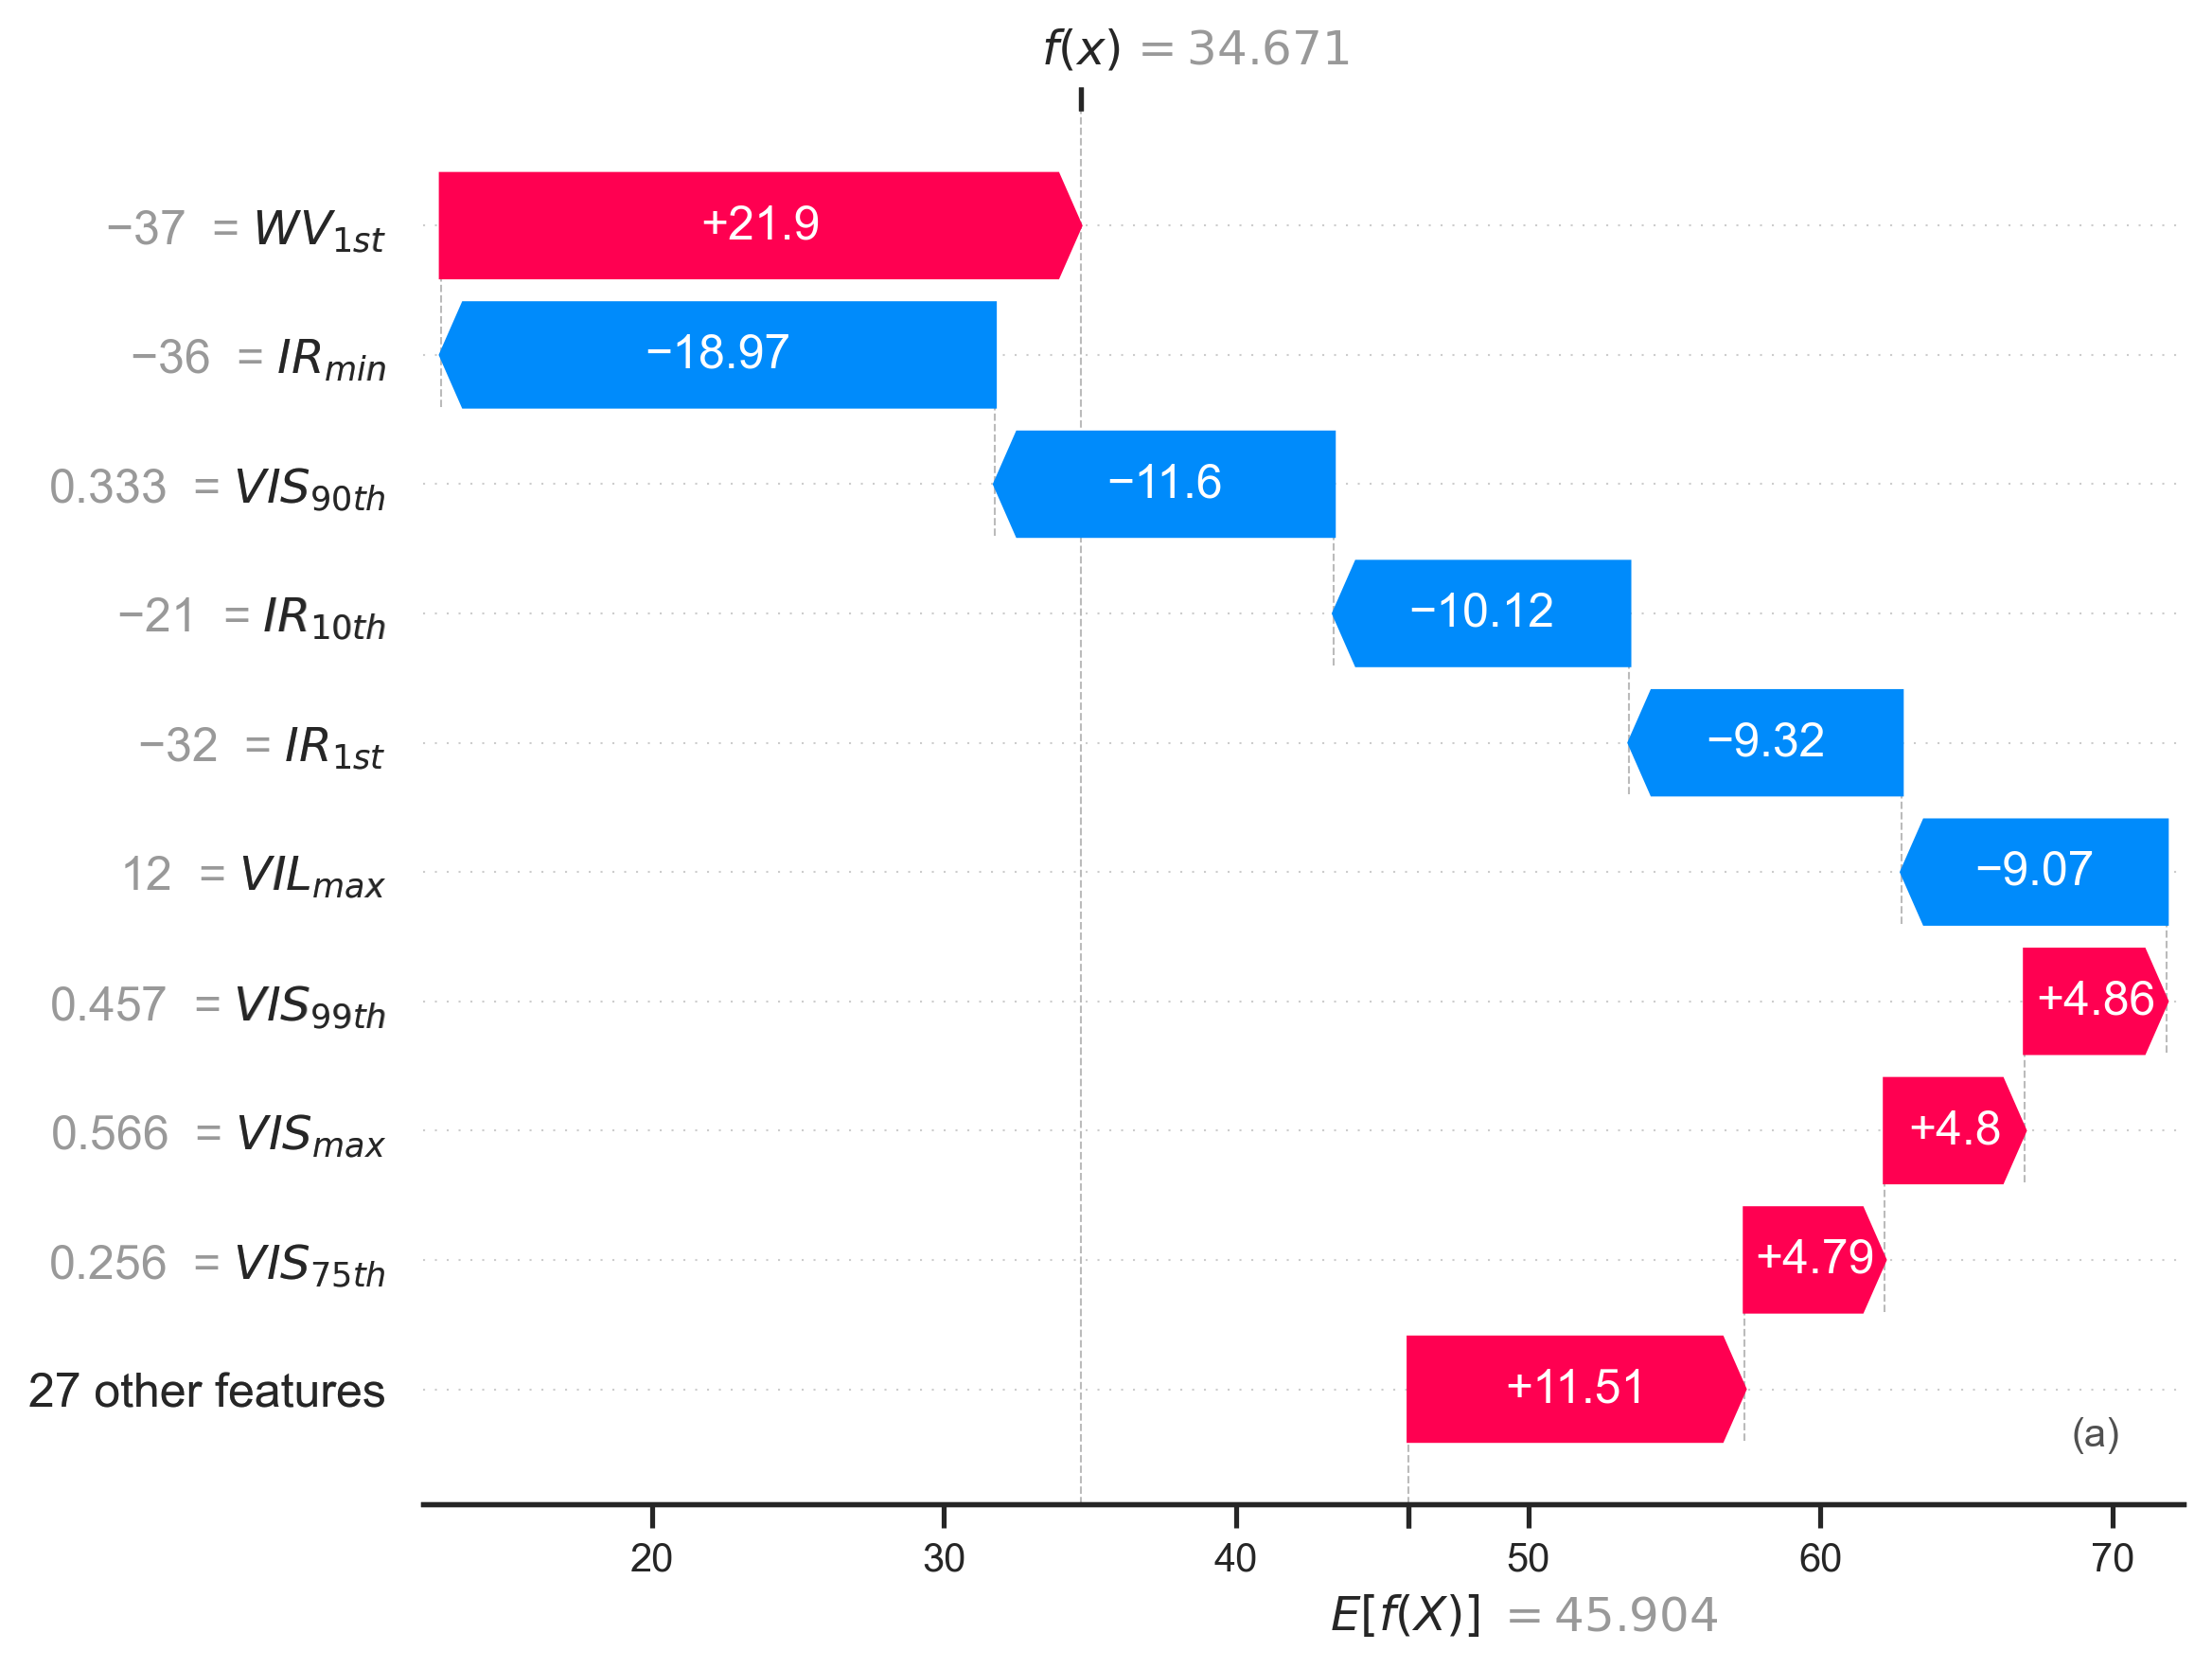

In [35]:
from skexplain.common.contrib_utils import get_indices_based_on_performance

# This code from skexplain finds 'n_samples' of the best hits, 
# worst false alarms, worst misses, and best correct negatives.
inds = get_indices_based_on_performance(estimators[0][1], X_test, y_test, 
                                        estimator_output='probability', n_samples=500)

# Let's use the last worst miss. We want a more marginal miss rather than 
# a worst case miss. 
idx = inds['Worst Misses'][-1]

explainer = skexplain.ExplainToolkit(estimators, X_test.iloc[[idx]], [y_test[idx]])

results = explainer.local_contributions(method='shap',
                                        performance_based=False,
                                       shap_kwargs={'masker' : 
                                      shap.maskers.Partition(X_train, 
                                                             max_samples=100, clustering="correlation"), 
                                     'algorithm' : 'auto'}
                                          )

fig = explainer.plot_contributions(contrib=results,  
                            display_feature_names=display_feature_names,
                        )

In this case, "warmer" IR$_{min}$ temperatures are substantially lowering the prediction. This contribution from IR$_{min}$ aligns with its expected contribution for a value of -36 based on the ALE curve above. There is also negative contribution from other IR-based features and the VIL$_{max}$. In the following cell, we have an animation for this time period. As we can see this is a largely marginal convective event with warm IR temperatures (ir107). The event is also taking place at night as the visible satellite imagery (vis) is completely dark. 


 </div> <div class="alert alert-block alert-info"><b>Question 5: </b> Do you think including visible satellite data is playing a negative role in model? Is successfully predicing nighttime lightning flashes a potential failure mode? </div>
 
 
 </div> <div class="alert alert-block alert-info"><b>Question 6: </b> How would you convert the above figure into an explanation for an end-user?  </div>

In [37]:
from IPython.display import Video
Video("another_scene.mp4")